In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import seaborn as sn
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.utils import resample

nlp = spacy.blank('id')
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
komentar = df['komentar'].astype(str)

# Huruf kecil
komentar = komentar.apply(lambda x: x.lower())

# Hapus URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

# Hapus angka
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

# Hapus tanda baca
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Hapus diluar alphabet dan numeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

# Tokenizing data
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df['label'].value_counts()

negatif    1101
positif    1017
netral      997
Name: label, dtype: int64

In [5]:
df = df[df.komentar.astype(bool)]

df_pos = df[df['label'] == 'positif']
X_pos_text = df_pos['komentar']
y_pos_label = df_pos['label']

df_neg = df[df['label'] == 'negatif']
X_neg_text = df_neg['komentar']
y_neg_label = df_neg['label']

df_net = df[df['label'] == 'netral']
X_net_text = df_net['komentar']
y_net_label = df_net['label']

In [6]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos_text, y_pos_label, test_size=0.2, random_state=1, stratify=y_pos_label)
X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg_text, y_neg_label, test_size=0.2, random_state=1, stratify=y_neg_label)
X_net_train, X_net_test, y_net_train, y_net_test = train_test_split(X_net_text, y_net_label, test_size=0.2, random_state=1, stratify=y_net_label)

In [7]:
X_pos_train_down = resample(X_pos_train, replace=True, n_samples=int(len(X_net_train)))
y_pos_train_down = resample(y_pos_train, replace=True, n_samples=int(len(y_net_train)))

X_neg_train_down = resample(X_neg_train, replace=True, n_samples=int(len(X_net_train)))
y_neg_train_down = resample(y_neg_train, replace=True, n_samples=int(len(y_net_train)))

In [8]:
X_train = pd.concat([X_net_train, X_pos_train_down])
X_train = pd.concat([X_train, X_neg_train_down])
y_train = pd.concat([y_net_train, y_pos_train_down])
y_train = pd.concat([y_train, y_neg_train_down])

X_test = pd.concat([X_net_test, X_pos_test])
X_test = pd.concat([X_test, X_neg_test])
y_test = pd.concat([y_net_test, y_pos_test])
y_test = pd.concat([y_test, y_neg_test])

In [9]:
print(y_train.value_counts())

positif    797
negatif    797
netral     797
Name: label, dtype: int64


In [10]:
from gensim.models.fasttext import FastText
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc = preprocessing.LabelEncoder()
lc.fit(y_train)

LabelEncoder()

In [14]:
y_train_enc = lc.transform(y_train)
y_test_enc = lc.transform(y_test)

In [15]:
train = xgb.DMatrix(X_train_vector,label=y_train_enc)
test = xgb.DMatrix(X_test_vector,label=y_test_enc)

In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y_train))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.28900	test-merror:0.57280
[1]	train-merror:0.20368	test-merror:0.54880
[2]	train-merror:0.16478	test-merror:0.51680
[3]	train-merror:0.13342	test-merror:0.49760
[4]	train-merror:0.11836	test-merror:0.49920
[5]	train-merror:0.10498	test-merror:0.49120
[6]	train-merror:0.10079	test-merror:0.48960
[7]	train-merror:0.08741	test-merror:0.48640
[8]	train-merror:0.08532	test-merror:0.47040
[9]	train-merror:0.07821	test-merror:0.46560
[10]	train-merror:0.07528	test-merror:0.45920
[11]	train-merror:0.07068	test-merror:0.45920
[12]	train-merror:0.07110	test-merror:0.46080
[13]	train-merror:0.06692	test-merror:0.45440
[14]	train-merror:0.06315	test-merror:0.46080
[15]	train-merror:0.05897	test-merror:0.44800
[16]	train-merror:0.06023	test-merror:0.44640
[17]	train-merror:0.05813	test-merror:0.43360
[18]	train-merror:0.05604	test-merror:0.43840
[19]	train-merror:0.05270	test-merror:0.44320
[20]	train-merror:0.05312	test-merror:0.45440
[21]	train-merror:0.05312	test-merror:0.4448

[177]	train-merror:0.01798	test-merror:0.40160
[178]	train-merror:0.01798	test-merror:0.40320
[179]	train-merror:0.01757	test-merror:0.40160
[180]	train-merror:0.01757	test-merror:0.40160
[181]	train-merror:0.01715	test-merror:0.40320
[182]	train-merror:0.01757	test-merror:0.40160
[183]	train-merror:0.01715	test-merror:0.40000
[184]	train-merror:0.01673	test-merror:0.39840
[185]	train-merror:0.01715	test-merror:0.39840
[186]	train-merror:0.01715	test-merror:0.39840
[187]	train-merror:0.01589	test-merror:0.40160
[188]	train-merror:0.01673	test-merror:0.40320
[189]	train-merror:0.01589	test-merror:0.40160
[190]	train-merror:0.01589	test-merror:0.40000
[191]	train-merror:0.01589	test-merror:0.39840
[192]	train-merror:0.01589	test-merror:0.39840
[193]	train-merror:0.01589	test-merror:0.40000
[194]	train-merror:0.01589	test-merror:0.40160
[195]	train-merror:0.01547	test-merror:0.40160
[196]	train-merror:0.01631	test-merror:0.40160
[197]	train-merror:0.01631	test-merror:0.40160
[198]	train-m

[352]	train-merror:0.00711	test-merror:0.39360
[353]	train-merror:0.00711	test-merror:0.39360
[354]	train-merror:0.00669	test-merror:0.39520
[355]	train-merror:0.00711	test-merror:0.39360
[356]	train-merror:0.00711	test-merror:0.39520
[357]	train-merror:0.00711	test-merror:0.39360
[358]	train-merror:0.00669	test-merror:0.39360
[359]	train-merror:0.00627	test-merror:0.39360
[360]	train-merror:0.00585	test-merror:0.39360
[361]	train-merror:0.00585	test-merror:0.39360
[362]	train-merror:0.00544	test-merror:0.39360
[363]	train-merror:0.00544	test-merror:0.39360
[364]	train-merror:0.00544	test-merror:0.39360
[365]	train-merror:0.00544	test-merror:0.39200
[366]	train-merror:0.00544	test-merror:0.39360
[367]	train-merror:0.00544	test-merror:0.39200
[368]	train-merror:0.00544	test-merror:0.39200
[369]	train-merror:0.00544	test-merror:0.39200
[370]	train-merror:0.00544	test-merror:0.39200
[371]	train-merror:0.00544	test-merror:0.39200
[372]	train-merror:0.00544	test-merror:0.39200
[373]	train-m

[527]	train-merror:0.00167	test-merror:0.38400
[528]	train-merror:0.00167	test-merror:0.38560
[529]	train-merror:0.00167	test-merror:0.38560
[530]	train-merror:0.00167	test-merror:0.38560
[531]	train-merror:0.00167	test-merror:0.38560
[532]	train-merror:0.00167	test-merror:0.38560
[533]	train-merror:0.00167	test-merror:0.38560
[534]	train-merror:0.00167	test-merror:0.38400
[535]	train-merror:0.00167	test-merror:0.38560
[536]	train-merror:0.00167	test-merror:0.38560
[537]	train-merror:0.00167	test-merror:0.38400
[538]	train-merror:0.00167	test-merror:0.38400
[539]	train-merror:0.00167	test-merror:0.38400
[540]	train-merror:0.00167	test-merror:0.38400
[541]	train-merror:0.00126	test-merror:0.38400
[542]	train-merror:0.00167	test-merror:0.38400
[543]	train-merror:0.00167	test-merror:0.38400
[544]	train-merror:0.00126	test-merror:0.38400
[545]	train-merror:0.00126	test-merror:0.38400
[546]	train-merror:0.00126	test-merror:0.38400
[547]	train-merror:0.00126	test-merror:0.38240
[548]	train-m

[702]	train-merror:0.00042	test-merror:0.37760
[703]	train-merror:0.00042	test-merror:0.37760
[704]	train-merror:0.00042	test-merror:0.37760
[705]	train-merror:0.00042	test-merror:0.37760
[706]	train-merror:0.00042	test-merror:0.37760
[707]	train-merror:0.00042	test-merror:0.37760
[708]	train-merror:0.00042	test-merror:0.37600
[709]	train-merror:0.00042	test-merror:0.37760
[710]	train-merror:0.00042	test-merror:0.37760
[711]	train-merror:0.00042	test-merror:0.37600
[712]	train-merror:0.00042	test-merror:0.37760
[713]	train-merror:0.00042	test-merror:0.37760
[714]	train-merror:0.00042	test-merror:0.37760
[715]	train-merror:0.00042	test-merror:0.37760
[716]	train-merror:0.00042	test-merror:0.37920
[717]	train-merror:0.00042	test-merror:0.37760
[718]	train-merror:0.00042	test-merror:0.37760
[719]	train-merror:0.00042	test-merror:0.37920
[720]	train-merror:0.00042	test-merror:0.37600
[721]	train-merror:0.00042	test-merror:0.37600
[722]	train-merror:0.00042	test-merror:0.37600
[723]	train-m

[877]	train-merror:0.00042	test-merror:0.37120
[878]	train-merror:0.00042	test-merror:0.37120
[879]	train-merror:0.00042	test-merror:0.37120
[880]	train-merror:0.00042	test-merror:0.37120
[881]	train-merror:0.00000	test-merror:0.37120
[882]	train-merror:0.00000	test-merror:0.37120
[883]	train-merror:0.00000	test-merror:0.37120
[884]	train-merror:0.00000	test-merror:0.37120
[885]	train-merror:0.00000	test-merror:0.37120
[886]	train-merror:0.00000	test-merror:0.37120
[887]	train-merror:0.00000	test-merror:0.37120
[888]	train-merror:0.00042	test-merror:0.37120
[889]	train-merror:0.00042	test-merror:0.37120
[890]	train-merror:0.00042	test-merror:0.37120
[891]	train-merror:0.00000	test-merror:0.37120
[892]	train-merror:0.00000	test-merror:0.37120
[893]	train-merror:0.00000	test-merror:0.37120
[894]	train-merror:0.00000	test-merror:0.37120
[895]	train-merror:0.00000	test-merror:0.37120
[896]	train-merror:0.00000	test-merror:0.37120
[897]	train-merror:0.00000	test-merror:0.37120
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6224 

Train Score
 1.0 

CONFUSSION MATRIX
 [[139  63  19]
 [ 34 141  25]
 [ 20  75 109]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.72      0.63      0.67       221
      netral       0.51      0.70      0.59       200
     positif       0.71      0.53      0.61       204

    accuracy                           0.62       625
   macro avg       0.65      0.62      0.62       625
weighted avg       0.65      0.62      0.63       625
 



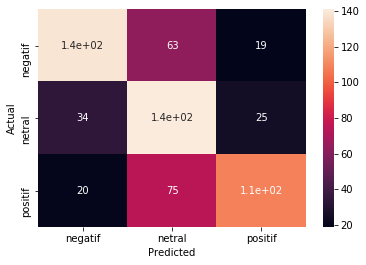

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
# #                "max_depth": [2, 4, 7, 10],
# #                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
# #                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
# #                "reg_alpha": [0, 0.5, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5],
# #                "min_child_weight": [1, 3, 5, 7],
# #                "n_estimators": [100, 250, 500, 1000]}

# parameters = {"learning_rate": [0.001, 0.01, 0.1, 0.4],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10, 12],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0.001, 0.01, 0.025, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])